In [1]:
%matplotlib inline
# Import standard python libraries
import numpy as np
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
# Import Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import portfolio
from qiskit.aqua.translators.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA, COBYLA
from qiskit.aqua.components.variational_forms import RY
import qiskit.aqua.translators.ising.vehicle_routing as vr

In [2]:
#Functions

#Get distance matrix between the nodes using Bing API
def get_distance_matrix_using_bing(xs_orig,ys_orig):
    import json 
    df = pd.DataFrame(list(zip(xs_orig, ys_orig)), columns =['latitude', 'longitude']) 
    data = df.to_json(orient='records')
    json_data = json.loads(data)

    API_KEY = "AhvV9TEJtcdH22s1KOa-cq-y_t58dasKFhVEXTb2In-SPwH-f3KFFqbxd2aWQttX"

    postman_submit = {}
    postman_submit ['origins'] = json_data
    postman_submit ['travelMode']=  "driving" #= {'driving'}
    postman_submit ['destination'] = json_data
    #postman_submit ['key'] = API_KEY
    postman_submit["distanceUnit"]="mi"
    
    import requests 
    # defining the api-endpoint 
    API_ENDPOINT = "http://dev.virtualearth.net/REST/v1/Routes/DistanceMatrix?key=AhvV9TEJtcdH22s1KOa-cq-y_t58dasKFhVEXTb2In-SPwH-f3KFFqbxd2aWQttX"

    headers = { 'Content-Length': str(len(json.dumps(postman_submit))),
    'Content-Type' : 'application/json'}
    response = requests.post(url = API_ENDPOINT, headers=headers, json = postman_submit)#,  params = postman_submit)
    print(response.status_code)

    if response:
        print('Success!')
    else:
        print('An error has occurred.')

    response_data  = response.json()
    resourceSets = response_data['resourceSets']
    destination_lat_long = resourceSets [0]['resources'][0]['destinations']
    origins_lat_long = resourceSets [0]['resources'][0]['origins']
    result_distance = resourceSets [0]['resources'][0] ['results']

    count = 0
    final_distance_matrix = []
    for i in range (0, len(origins_lat_long)):
            #print("origin: ", lat_long[i])
            dist = []
            for j in range (0, len(destination_lat_long)):
                #print ("i: {}, j : {}: ".format(i,j))
                if(i>j):
                    dist.append(final_distance_matrix[j][i])
                    count +=1
                elif(i == j):
                    dist.append(0.0)
                else:
                    dist.append(result_distance[count]['travelDistance'])
                    count +=1
                #print("This is the distance: ", dist)
            if(len(dist) != 0):
                #print(dist)
                final_distance_matrix.append(dist)
    return final_distance_matrix

In [3]:
#Function : Find cluster of 3 nodes based on shortest distance from given distance matriz
def get_cluster_3_sd(in_data):
    total_node = len(in_data)
    in_data_list = []
    node_data_list = []
    
    #gathering distance list with nodes from disstance matrix
    for i in range(total_node):
        node_list = []
        for j in range(total_node):
            if i != j:
                in_data_list.append([in_data[i][j], i, j])
                node_list.append([in_data[i][j], j])
        node_data_list.append(node_list)
    
    #shorting the list on distance
    sorted_in_data_list = in_data_list.copy()
    sorted_in_data_list.sort(key = lambda x: x[0]) 
    sorted_node_data_list = node_data_list.copy()
    
    for i in range(total_node):
        sorted_node_data_list[i].sort(key = lambda x: x[0])
        
    #initializing list and values
    unsed_node = {}
    for i in range(total_node):
        unsed_node[i] = True
        
    node_clustered_count = 0    
    cluster_list = []
    dist_calculated = 0
    
    #generating clusters based on shortest distance
    for i in range(len(sorted_in_data_list)):
        #calculating if more than 3 nodes are still not assigned to cluster
        if node_clustered_count < total_node - 3:
            #finding first two nodes
            node_1 = sorted_in_data_list[i][1]
            node_2 = sorted_in_data_list[i][2]
            if (not unsed_node[node_1]) or (not unsed_node[node_2]):
                continue

            dist_calculated += in_data[node_1][node_2]
            unsed_node[node_1] = False
            unsed_node[node_2] = False

            #finding 3rd node
            for i in range(total_node):
                if unsed_node[sorted_node_data_list[node_1][i][1]]:
                    node_1_3_dist = sorted_node_data_list[node_1][i][0]
                    node_1_3 = sorted_node_data_list[node_1][i][1]
                    break
            for i in range(total_node):
                if unsed_node[sorted_node_data_list[node_2][i][1]]:
                    node_2_3_dist = sorted_node_data_list[node_2][i][0]
                    node_2_3 = sorted_node_data_list[node_2][i][1]
                    break

            if node_1_3_dist < node_2_3_dist:
                node_3 = node_1_3
                dist_calculated += in_data[node_1][node_3]
            else:
                node_3 = node_2_3
                dist_calculated += in_data[node_2][node_3]

            #creating cluster with 3 nodes
            cluster_list_append = [node_1, node_2, node_3]
            cluster_list_append.sort()
            cluster_list.append(cluster_list_append)
            node_clustered_count += 3
            unsed_node[node_3] = False
        #arranging for not more than 3 nodes
        else:
            #finding nodes which are not assigned to cluster
            cluster_list_append = []
            found_flag = False
            for i in range(total_node):
                if unsed_node[i]:
                    found_flag = True
                    cluster_list_append.append(i)
                    unsed_node[i] = False

            #calculating for rest of the nodes
            if found_flag:
                cluster_list_append.sort()
                cluster_list.append(cluster_list_append)
                if len(cluster_list_append) == 2:
                    dist_1 = in_data[cluster_list_append[0]][cluster_list_append[1]]
                    dist_calculated += dist_1
                elif len(cluster_list_append) == 3:
                    dist_1 = in_data[cluster_list_append[0]][cluster_list_append[1]] +\
                             in_data[cluster_list_append[1]][cluster_list_append[2]]
                    dist_2 = in_data[cluster_list_append[1]][cluster_list_append[2]] +\
                             in_data[cluster_list_append[2]][cluster_list_append[0]]
                    dist_3 = in_data[cluster_list_append[2]][cluster_list_append[0]] +\
                             in_data[cluster_list_append[0]][cluster_list_append[1]]
                    min_dist = min(dist_1, dist_2, dist_3)
                    dist_calculated += min_dist
            break

    return cluster_list, dist_calculated

In [4]:
# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1)
K = 1  # number of vehicles
#Number of zones
no_zones=12

In [5]:
#Input Training Data, columns: Age, Annual Income, Annual Spend
input_data = eval(open('vehicle_routing_nodes.txt', 'r').read())

In [6]:
xAllNodes = input_data['x']
yAllNodes = input_data['y']
#Hub Coordinates - these are included as the first elements in the data file
#x0 = 40.72374; y0 = -73.99239
x0 = xAllNodes[0]; y0 = yAllNodes[0]
#Customer coordinates
xs_orig = np.array(xAllNodes[1:])
ys_orig = np.array(yAllNodes[1:])
print(xs_orig)
print(ys_orig)

[40.72102 40.71824 40.72633 40.72828 40.75074 40.75213 40.75651 40.76173
 40.77631 40.77553 40.77236 40.7793  40.76912 40.75305 40.74885 40.74704
 40.74558 40.73917 40.73677 40.73691 40.72907 40.72282 40.70914 40.70553
 40.70409 40.72158 40.70302 40.72296 40.7254  40.74732 40.73789 40.73809
 40.74867 40.75831 40.78155 40.7912 ]
[-73.983 -73.988 -73.978 -74.01  -74.004 -73.98  -73.992 -73.994 -73.983
 -73.953 -73.927 -73.916 -73.905 -73.933 -73.941 -73.953 -73.905 -73.92
 -73.955 -73.899 -73.92  -73.901 -73.907 -73.894 -73.931 -73.94  -73.987
 -74.047 -74.069 -74.062 -74.053 -74.028 -74.041 -74.044 -74.051 -74.009]


In [7]:
#Create distance matrix using Bing API
#distance matrix with the hub
distance_matrix = get_distance_matrix_using_bing(np.array(xAllNodes), np.array(yAllNodes))
distance_matrix = np.matrix(distance_matrix)
#distance matrix without the hub
distance_matrix_for_zone = get_distance_matrix_using_bing(xs_orig,ys_orig)
print(distance_matrix)

200
Success!
200
Success!
[[0.    0.579 0.679 ... 5.324 7.921 7.581]
 [0.579 0.    0.587 ... 5.911 8.883 8.543]
 [0.679 0.587 0.    ... 5.708 8.632 8.292]
 ...
 [5.324 5.911 5.708 ... 0.    2.927 4.58 ]
 [7.921 8.883 8.632 ... 2.927 0.    3.972]
 [7.581 8.543 8.292 ... 4.58  3.972 0.   ]]


In [8]:
# Clustering of the customer nodes
clusters, total_dist = get_cluster_3_sd(distance_matrix_for_zone)
print("zone from SP's code...")
print(clusters, total_dist)
#In these clusters customer nodes are from 0,1,...
#Since we have 0th node as the hub, we need to add 1 to each of these nodes within the zones
zonecount=0;nodecount=0
zones = [[]]*len(clusters)
nodes = {0:{'x':x0, 'y':y0, 'color':'#bbbb00','id':0}}

for zone in clusters:
    zones[zonecount] = [0]
    for node in zone:
        updated_node = node + 1
        zones[zonecount].append(updated_node)
        nodes[updated_node] = {'x':xs_orig[node],'y':ys_orig[node], 'color':'#00bbee', 'id':(updated_node)}
    zonecount = zonecount + 1
print(zones,"===",nodes)

zone from SP's code...
[[5, 6, 7], [0, 1, 2], [30, 32, 33], [10, 11, 12], [16, 17, 20], [19, 21, 22], [13, 15, 18], [27, 28, 29], [23, 24, 25], [3, 4, 8], [9, 14, 26], [31, 34, 35]] 46.757
[[0, 6, 7, 8], [0, 1, 2, 3], [0, 31, 33, 34], [0, 11, 12, 13], [0, 17, 18, 21], [0, 20, 22, 23], [0, 14, 16, 19], [0, 28, 29, 30], [0, 24, 25, 26], [0, 4, 5, 9], [0, 10, 15, 27], [0, 32, 35, 36]] === {0: {'x': 40.72374, 'y': -73.99239, 'color': '#bbbb00', 'id': 0}, 6: {'x': 40.75213, 'y': -73.98, 'color': '#00bbee', 'id': 6}, 7: {'x': 40.75651, 'y': -73.992, 'color': '#00bbee', 'id': 7}, 8: {'x': 40.76173, 'y': -73.994, 'color': '#00bbee', 'id': 8}, 1: {'x': 40.72102, 'y': -73.983, 'color': '#00bbee', 'id': 1}, 2: {'x': 40.71824, 'y': -73.988, 'color': '#00bbee', 'id': 2}, 3: {'x': 40.72633, 'y': -73.978, 'color': '#00bbee', 'id': 3}, 31: {'x': 40.73789, 'y': -74.053, 'color': '#00bbee', 'id': 31}, 33: {'x': 40.74867, 'y': -74.041, 'color': '#00bbee', 'id': 33}, 34: {'x': 40.75831, 'y': -74.044, 'col

In [9]:
def get_xs_and_ys_for_a_zone (zone_id):
    xs=[] ; ys=[]
    i=0
    for node in zones[zone_id]:
        xs.append(nodes.get(node).get('x'))
        ys.append(nodes.get(node).get('y'))
        i=i+1
    return xs,ys

#Create a random customer-customer distance matrix
def create_distance_matrix_for_zone(zone_id):
    if (zone_id>=0):
        nodes1 = zones[zone_id]
    #print (nodes1)
    abc = distance_matrix[np.ix_(nodes1,nodes1)]
    #print(abc)
    return abc

#Create a random customer-customer distance matrix
def create_euclidian_distance_matrix_for_zone(zone_id):
    if (zone_id>=0):
        xs, ys = get_xs_and_ys_for_a_zone(zone_id)
    else:
        xs, ys = xs_orig, ys_orig

    n=len(xs)
    instance = np.zeros([n, n])
    for i in range(0, n):
        for j in range(i + 1, n):
            #print ('nodes = ',(xs[i],ys[i]),(xs[j],ys[j]))
            #Distance squared
            #instance[i, j] = (xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2
            instance[i, j] = math.sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
            #jith element is made the same as ijth element - so that the matrix is a symmetric
            instance[j, i] = instance[i, j]
            #print (instance[i,j])
    return instance

def plot_nodes (graph, zone_id):
    xs, ys = get_xs_and_ys_for_a_zone(zone_id)
    nodelist=zones[zone_id]
    # plt.gca().invert_yaxis()
    # plt.gca().invert_xaxis()
    n=len(xs)
    print('length of n/xs:',n)
    keys = range(len(xs))
    i=0
    for k in nodelist:
        pos[k] = (xs[i], ys[i])
        i=i+1
    print(pos)
    plt.figure()
    fig = plt.gcf()
    ax=fig.gca()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Add Edges
    #for i in keys:
    #    for j in range(i+1, n):
    #        X.add_edge(i, j, length=int(instance[i][j]))
    # Add Edges
    i=0;j=1
    print('nodelist:',nodelist)
    for i in range(len(nodelist)):
        for j in range(i+1, n):
            print(i,'..',j)
            node_a=nodelist[i]; node_b=nodelist[j]
            print('X:',X,'...node a:',node_a,'..node b:',node_b,'...length:',int(instance[node_a,node_b]))
            #X.add_edge(node_a, node_b, length=int(instance[i][j]))
            X.add_edge(node_a, node_b, length=int(instance[node_a,node_b]))

    nx.draw_networkx(graph, pos, node_size=350, edge_color='#cccccc',ax=ax,
                     nodelist=nodelist, node_color='#00bbee', alpha=0.7, with_labels=True)
    labels = nx.get_edge_attributes(graph, "length")
    print(labels)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    #plt.grid(True)
    plt.show()

def get_hamiltonian_paths(graph, target):
    allpaths = nx.all_simple_paths(graph, source=0, target=target)
    #Print Hamiltonian Paths
    selectedPaths = [path for path in list(allpaths) if len(path)==4]
    return selectedPaths   

def get_min_cost_function(selectedPaths) :
    min_cost=100000
    min_cost_path = None
    for path in list(selectedPaths):
        total_length=0
        for k in range(len(path)-1):
            x,y = path[k], path[k+1]
            edge = X[x][y]
            #print (path, x, y)
            length = distance_matrix[x,y]
            #print (path, x, y, length)
            total_length += length
        print('{}: {}'.format(path, total_length))
        if min_cost>total_length:
            min_cost=total_length
            min_cost_path = path
    return min_cost, min_cost_path
# Visualize the solution
def draw_tsp_solution(G, order, pos):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph : Cost = '+ str(min_cost))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()

    #G1 = G.copy()
    G1 = nx.Graph()
    #edges = list(G1.edges())
    #G2 = G1.remove_edges_from(edges)
    G1 = G1.to_directed()
    n = len(order)
    i=0;j=1
    for i in range(len(order)-1):
        j=i+1
        node_a=order[i]; node_b=order[i+1]
        print (node_a,node_b, 'length: ',instance[node_a][node_b])
        G1.add_edge(node_a, node_b, length=int(instance[node_a][node_b]))
    G1.add_edge(order[j], order[0],length=int(instance[node_b][0]))
    """
    for i in range(n-1):
        j = (i+1)#(i + 1) % n
        print(order[i],order[j])
        G1.add_edge(order[i], order[j],length=int(instance[order[i]][order[j]]))
    G1.add_edge(order[j], order[0],length=int(instance[order[j]][order[0]]))
    """
    i=0
    for k in order:
        pos[k] = (nodes[k]['x'], nodes[k]['y']) #xs[i], ys[i])
        i=i+1
    print(pos)
    #create node colors array
    #colors = np.full(len(nodes),'#ffffff')
    colors = np.full(n,'#ffffff')
    for i in range(n):
        colors[i]=nodes[order[i]]['color']
        
    #hub_index=order[0]
    #colors[hub_index]='#bbbb00'
    default_axes = plt.axes(frameon=True)
    ax=fig.gca()
    
    #mapping = {0:0,1:4,2:5,3:6}
    #nx.relabel_nodes(G1,mapping,False)
    #nx.draw_networkx(G1, pos, node_size=350, edge_color='#cccccc', ax=ax, 
    #                 node_color=colors, alpha=0.7, arrowsize=20)
    colors = ['#bbbb00','#00bbee','#00bbee','#00bbee']
    nx.draw_networkx(G1, pos, node_size=350, edge_color='#cccccc',ax=ax,
                     nodelist=order, node_color=colors, alpha=0.7, arrowsize=20, with_labels=True)
    labels = nx.get_edge_attributes(G1, "length")
    print(labels)
    nx.draw_networkx_edge_labels(G1, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    plt.grid(True)
    plt.show()




----For Zone 0----
length of n/xs: 4
{0: (40.72374, -73.99239), 6: (40.75213, -73.98), 7: (40.75651, -73.992), 8: (40.76173, -73.994)}
nodelist: [0, 6, 7, 8]
0 .. 1
X:  ...node a: 0 ..node b: 6 ...length: 2
0 .. 2
X:  ...node a: 0 ..node b: 7 ...length: 3
0 .. 3
X:  ...node a: 0 ..node b: 8 ...length: 3
1 .. 2
X:  ...node a: 6 ..node b: 7 ...length: 1
1 .. 3
X:  ...node a: 6 ..node b: 8 ...length: 1
2 .. 3
X:  ...node a: 7 ..node b: 8 ...length: 0
{(0, 6): 2, (0, 7): 3, (0, 8): 3, (6, 7): 1, (6, 8): 1, (7, 8): 0}


/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


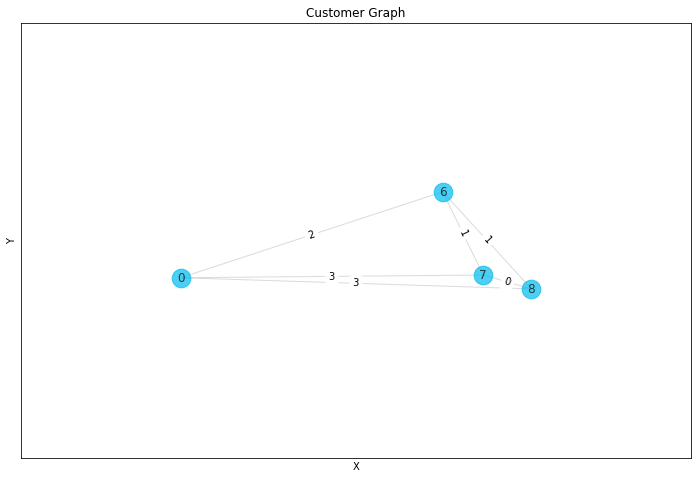

All Hamiltonian Paths from 0-8 :
 [[0, 6, 7, 8], [0, 7, 6, 8]] 

[0, 6, 7, 8]: 4.029
[0, 7, 6, 8]: 5.462
Minimum Cost for Zone 0: [0, 6, 7, 8] : 4.029

----For Zone 1----
length of n/xs: 4
{0: (40.72374, -73.99239), 1: (40.72102, -73.983), 2: (40.71824, -73.988), 3: (40.72633, -73.978)}
nodelist: [0, 1, 2, 3]
0 .. 1
X:  ...node a: 0 ..node b: 1 ...length: 0
0 .. 2
X:  ...node a: 0 ..node b: 2 ...length: 0
0 .. 3
X:  ...node a: 0 ..node b: 3 ...length: 1
1 .. 2
X:  ...node a: 1 ..node b: 2 ...length: 0
1 .. 3
X:  ...node a: 1 ..node b: 3 ...length: 0
2 .. 3
X:  ...node a: 2 ..node b: 3 ...length: 1
{(0, 1): 0, (0, 2): 0, (0, 3): 1, (1, 2): 0, (1, 3): 0, (2, 3): 1}


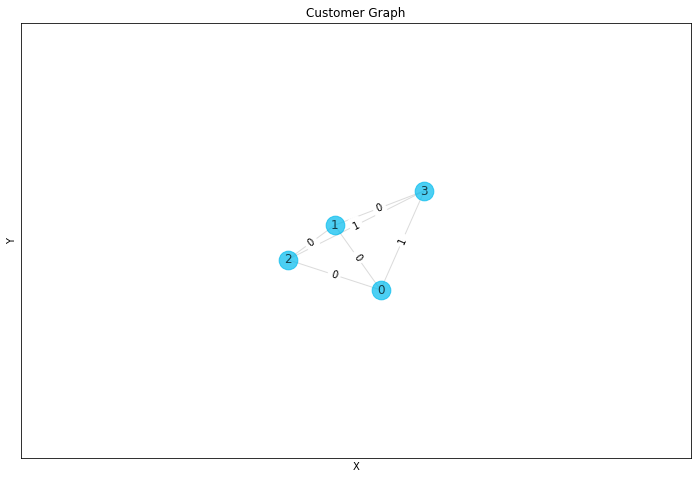

All Hamiltonian Paths from 0-3 :
 [[0, 1, 2, 3], [0, 2, 1, 3]] 

[0, 1, 2, 3]: 2.199
[0, 2, 1, 3]: 1.822
Minimum Cost for Zone 1: [0, 2, 1, 3] : 1.822

----For Zone 2----
length of n/xs: 4
{0: (40.72374, -73.99239), 31: (40.73789, -74.053), 33: (40.74867, -74.041), 34: (40.75831, -74.044)}
nodelist: [0, 31, 33, 34]
0 .. 1
X:  ...node a: 0 ..node b: 31 ...length: 4
0 .. 2
X:  ...node a: 0 ..node b: 33 ...length: 4
0 .. 3
X:  ...node a: 0 ..node b: 34 ...length: 5
1 .. 2
X:  ...node a: 31 ..node b: 33 ...length: 1
1 .. 3
X:  ...node a: 31 ..node b: 34 ...length: 1
2 .. 3
X:  ...node a: 33 ..node b: 34 ...length: 0
{(0, 31): 4, (0, 33): 4, (0, 34): 5, (31, 33): 1, (31, 34): 1, (33, 34): 0}


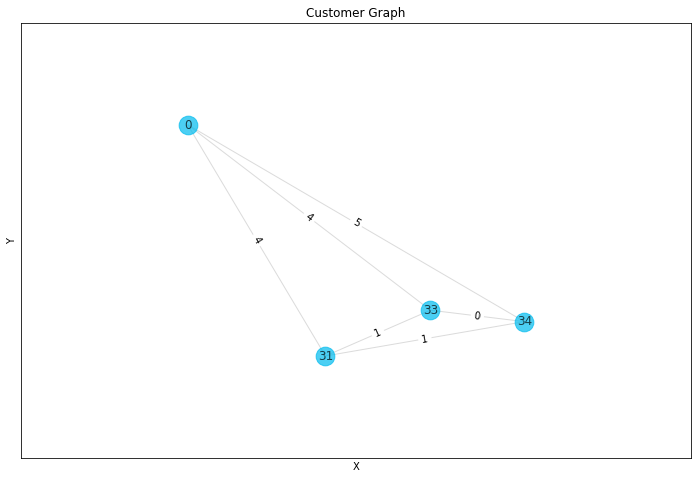

All Hamiltonian Paths from 0-34 :
 [[0, 31, 33, 34], [0, 33, 31, 34]] 

[0, 31, 33, 34]: 6.375
[0, 33, 31, 34]: 7.541000000000001
Minimum Cost for Zone 2: [0, 31, 33, 34] : 6.375

----For Zone 3----
length of n/xs: 4
{0: (40.72374, -73.99239), 11: (40.77236, -73.927), 12: (40.7793, -73.916), 13: (40.76912, -73.905)}
nodelist: [0, 11, 12, 13]
0 .. 1
X:  ...node a: 0 ..node b: 11 ...length: 9
0 .. 2
X:  ...node a: 0 ..node b: 12 ...length: 9
0 .. 3
X:  ...node a: 0 ..node b: 13 ...length: 8
1 .. 2
X:  ...node a: 11 ..node b: 12 ...length: 0
1 .. 3
X:  ...node a: 11 ..node b: 13 ...length: 1
2 .. 3
X:  ...node a: 12 ..node b: 13 ...length: 1
{(0, 11): 9, (0, 12): 9, (0, 13): 8, (11, 12): 0, (11, 13): 1, (12, 13): 1}


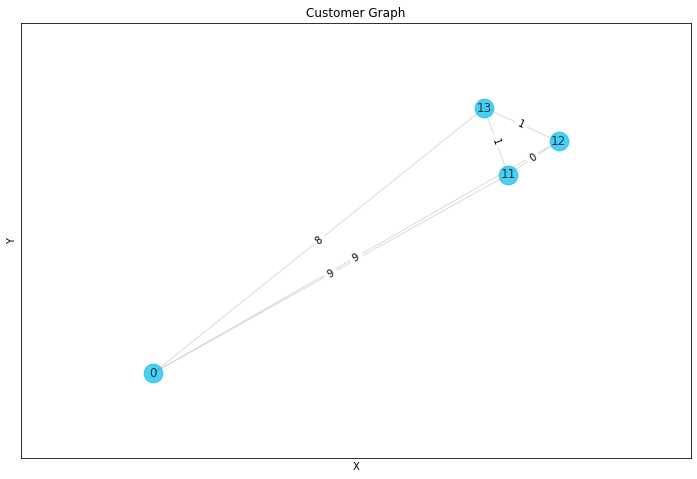

All Hamiltonian Paths from 0-13 :
 [[0, 11, 12, 13], [0, 12, 11, 13]] 

[0, 11, 12, 13]: 11.606
[0, 12, 11, 13]: 12.202
Minimum Cost for Zone 3: [0, 11, 12, 13] : 11.606

----For Zone 4----
length of n/xs: 4
{0: (40.72374, -73.99239), 17: (40.74558, -73.905), 18: (40.73917, -73.92), 21: (40.72907, -73.92)}
nodelist: [0, 17, 18, 21]
0 .. 1
X:  ...node a: 0 ..node b: 17 ...length: 6
0 .. 2
X:  ...node a: 0 ..node b: 18 ...length: 5
0 .. 3
X:  ...node a: 0 ..node b: 21 ...length: 5
1 .. 2
X:  ...node a: 17 ..node b: 18 ...length: 1
1 .. 3
X:  ...node a: 17 ..node b: 21 ...length: 1
2 .. 3
X:  ...node a: 18 ..node b: 21 ...length: 0
{(0, 17): 6, (0, 18): 5, (0, 21): 5, (17, 18): 1, (17, 21): 1, (18, 21): 0}


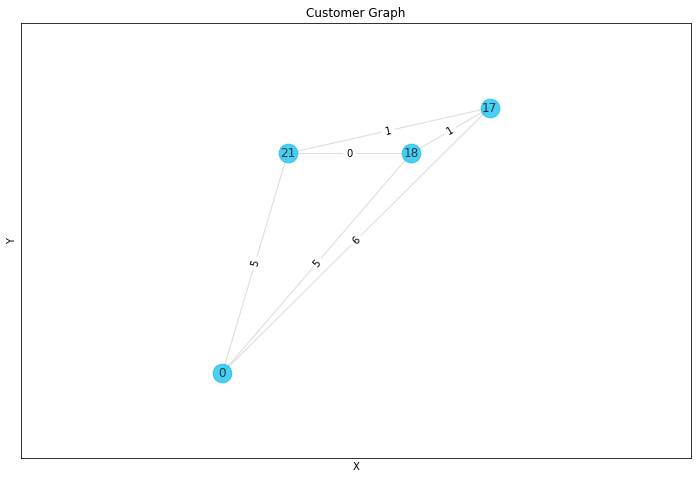

All Hamiltonian Paths from 0-21 :
 [[0, 17, 18, 21], [0, 18, 17, 21]] 

[0, 17, 18, 21]: 8.911999999999999
[0, 18, 17, 21]: 8.624
Minimum Cost for Zone 4: [0, 18, 17, 21] : 8.624

----For Zone 5----
length of n/xs: 4
{0: (40.72374, -73.99239), 20: (40.73691, -73.899), 22: (40.72282, -73.901), 23: (40.70914, -73.907)}
nodelist: [0, 20, 22, 23]
0 .. 1
X:  ...node a: 0 ..node b: 20 ...length: 6
0 .. 2
X:  ...node a: 0 ..node b: 22 ...length: 6
0 .. 3
X:  ...node a: 0 ..node b: 23 ...length: 6
1 .. 2
X:  ...node a: 20 ..node b: 22 ...length: 1
1 .. 3
X:  ...node a: 20 ..node b: 23 ...length: 2
2 .. 3
X:  ...node a: 22 ..node b: 23 ...length: 1
{(0, 20): 6, (0, 22): 6, (0, 23): 6, (20, 22): 1, (20, 23): 2, (22, 23): 1}


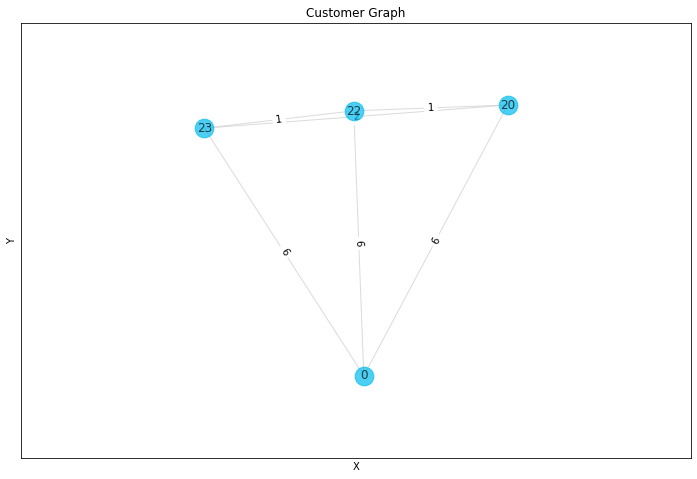

All Hamiltonian Paths from 0-23 :
 [[0, 20, 22, 23], [0, 22, 20, 23]] 

[0, 20, 22, 23]: 8.939
[0, 22, 20, 23]: 10.014
Minimum Cost for Zone 5: [0, 20, 22, 23] : 8.939

----For Zone 6----
length of n/xs: 4
{0: (40.72374, -73.99239), 14: (40.75305, -73.933), 16: (40.74704, -73.953), 19: (40.73677, -73.955)}
nodelist: [0, 14, 16, 19]
0 .. 1
X:  ...node a: 0 ..node b: 14 ...length: 4
0 .. 2
X:  ...node a: 0 ..node b: 16 ...length: 3
0 .. 3
X:  ...node a: 0 ..node b: 19 ...length: 4
1 .. 2
X:  ...node a: 14 ..node b: 16 ...length: 1
1 .. 3
X:  ...node a: 14 ..node b: 19 ...length: 2
2 .. 3
X:  ...node a: 16 ..node b: 19 ...length: 1
{(0, 14): 4, (0, 16): 3, (0, 19): 4, (14, 16): 1, (14, 19): 2, (16, 19): 1}


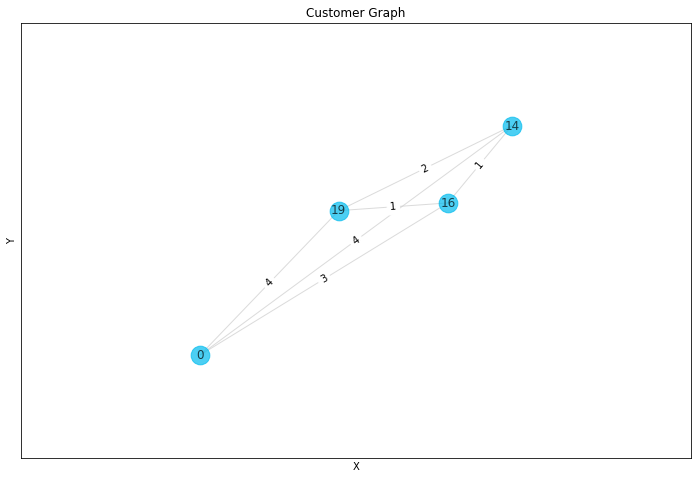

All Hamiltonian Paths from 0-19 :
 [[0, 14, 16, 19], [0, 16, 14, 19]] 

[0, 14, 16, 19]: 7.64
[0, 16, 14, 19]: 7.683
Minimum Cost for Zone 6: [0, 14, 16, 19] : 7.64

----For Zone 7----
length of n/xs: 4
{0: (40.72374, -73.99239), 28: (40.72296, -74.047), 29: (40.7254, -74.069), 30: (40.74732, -74.062)}
nodelist: [0, 28, 29, 30]
0 .. 1
X:  ...node a: 0 ..node b: 28 ...length: 4
0 .. 2
X:  ...node a: 0 ..node b: 29 ...length: 5
0 .. 3
X:  ...node a: 0 ..node b: 30 ...length: 5
1 .. 2
X:  ...node a: 28 ..node b: 29 ...length: 1
1 .. 3
X:  ...node a: 28 ..node b: 30 ...length: 2
2 .. 3
X:  ...node a: 29 ..node b: 30 ...length: 1
{(0, 28): 4, (0, 29): 5, (0, 30): 5, (28, 29): 1, (28, 30): 2, (29, 30): 1}


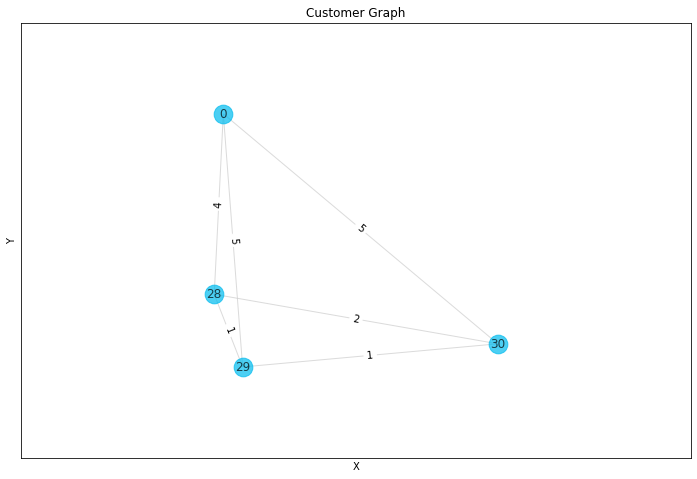

All Hamiltonian Paths from 0-30 :
 [[0, 28, 29, 30], [0, 29, 28, 30]] 

[0, 28, 29, 30]: 7.391
[0, 29, 28, 30]: 8.821
Minimum Cost for Zone 7: [0, 28, 29, 30] : 7.391

----For Zone 8----
length of n/xs: 4
{0: (40.72374, -73.99239), 24: (40.70553, -73.894), 25: (40.70409, -73.931), 26: (40.72158, -73.94)}
nodelist: [0, 24, 25, 26]
0 .. 1
X:  ...node a: 0 ..node b: 24 ...length: 7
0 .. 2
X:  ...node a: 0 ..node b: 25 ...length: 4
0 .. 3
X:  ...node a: 0 ..node b: 26 ...length: 3
1 .. 2
X:  ...node a: 24 ..node b: 25 ...length: 2
1 .. 3
X:  ...node a: 24 ..node b: 26 ...length: 3
2 .. 3
X:  ...node a: 25 ..node b: 26 ...length: 1
{(0, 24): 7, (0, 25): 4, (0, 26): 3, (24, 25): 2, (24, 26): 3, (25, 26): 1}


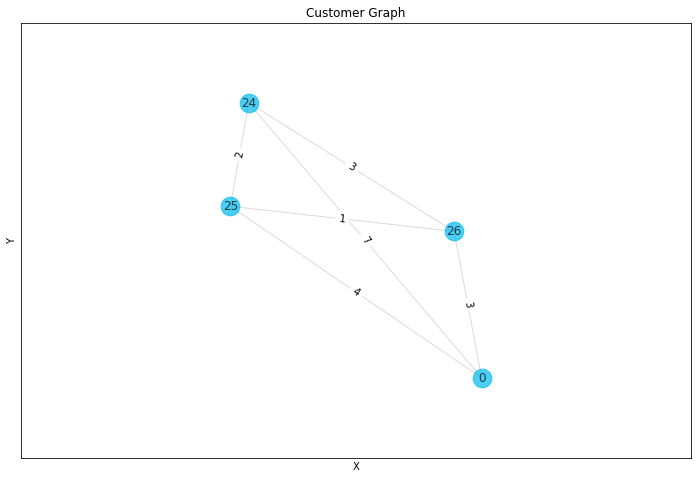

All Hamiltonian Paths from 0-26 :
 [[0, 24, 25, 26], [0, 25, 24, 26]] 

[0, 24, 25, 26]: 11.706999999999999
[0, 25, 24, 26]: 9.76
Minimum Cost for Zone 8: [0, 25, 24, 26] : 9.76

----For Zone 9----
length of n/xs: 4
{0: (40.72374, -73.99239), 4: (40.72828, -74.01), 5: (40.75074, -74.004), 9: (40.77631, -73.983)}
nodelist: [0, 4, 5, 9]
0 .. 1
X:  ...node a: 0 ..node b: 4 ...length: 1
0 .. 2
X:  ...node a: 0 ..node b: 5 ...length: 2
0 .. 3
X:  ...node a: 0 ..node b: 9 ...length: 5
1 .. 2
X:  ...node a: 4 ..node b: 5 ...length: 1
1 .. 3
X:  ...node a: 4 ..node b: 9 ...length: 4
2 .. 3
X:  ...node a: 5 ..node b: 9 ...length: 2
{(0, 4): 1, (0, 5): 2, (0, 9): 5, (4, 5): 1, (4, 9): 4, (5, 9): 2}


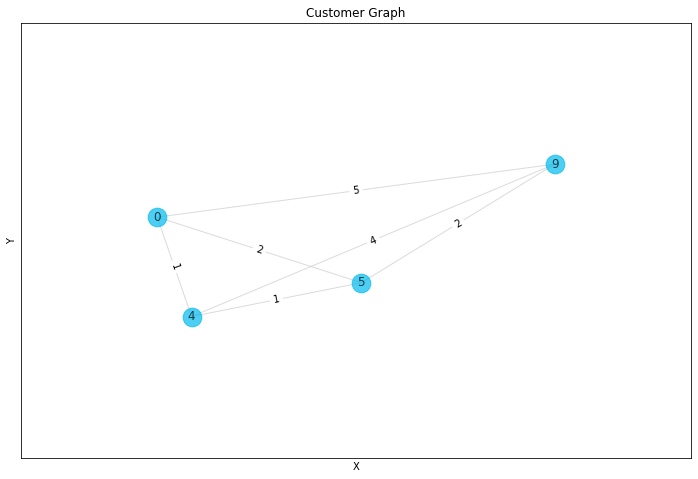

All Hamiltonian Paths from 0-9 :
 [[0, 4, 5, 9], [0, 5, 4, 9]] 

[0, 4, 5, 9]: 5.994
[0, 5, 4, 9]: 8.781
Minimum Cost for Zone 9: [0, 4, 5, 9] : 5.994

----For Zone 10----
length of n/xs: 4
{0: (40.72374, -73.99239), 10: (40.77553, -73.953), 15: (40.74885, -73.941), 27: (40.70302, -73.987)}
nodelist: [0, 10, 15, 27]
0 .. 1
X:  ...node a: 0 ..node b: 10 ...length: 4
0 .. 2
X:  ...node a: 0 ..node b: 15 ...length: 4
0 .. 3
X:  ...node a: 0 ..node b: 27 ...length: 2
1 .. 2
X:  ...node a: 10 ..node b: 15 ...length: 3
1 .. 3
X:  ...node a: 10 ..node b: 27 ...length: 8
2 .. 3
X:  ...node a: 15 ..node b: 27 ...length: 8
{(0, 10): 4, (0, 15): 4, (0, 27): 2, (10, 15): 3, (10, 27): 8, (15, 27): 8}


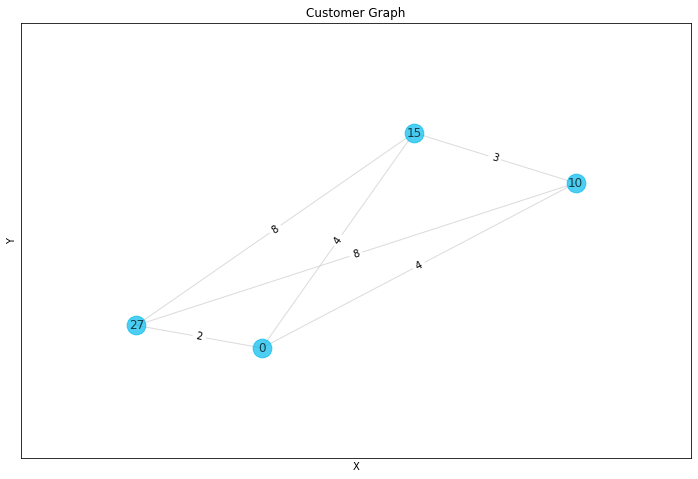

All Hamiltonian Paths from 0-27 :
 [[0, 10, 15, 27], [0, 15, 10, 27]] 

[0, 10, 15, 27]: 16.933999999999997
[0, 15, 10, 27]: 16.567999999999998
Minimum Cost for Zone 10: [0, 15, 10, 27] : 16.567999999999998

----For Zone 11----
length of n/xs: 4
{0: (40.72374, -73.99239), 32: (40.73809, -74.028), 35: (40.78155, -74.051), 36: (40.7912, -74.009)}
nodelist: [0, 32, 35, 36]
0 .. 1
X:  ...node a: 0 ..node b: 32 ...length: 4
0 .. 2
X:  ...node a: 0 ..node b: 35 ...length: 7
0 .. 3
X:  ...node a: 0 ..node b: 36 ...length: 7
1 .. 2
X:  ...node a: 32 ..node b: 35 ...length: 4
1 .. 3
X:  ...node a: 32 ..node b: 36 ...length: 5
2 .. 3
X:  ...node a: 35 ..node b: 36 ...length: 3
{(0, 32): 4, (0, 35): 7, (0, 36): 7, (32, 35): 4, (32, 36): 5, (35, 36): 3}


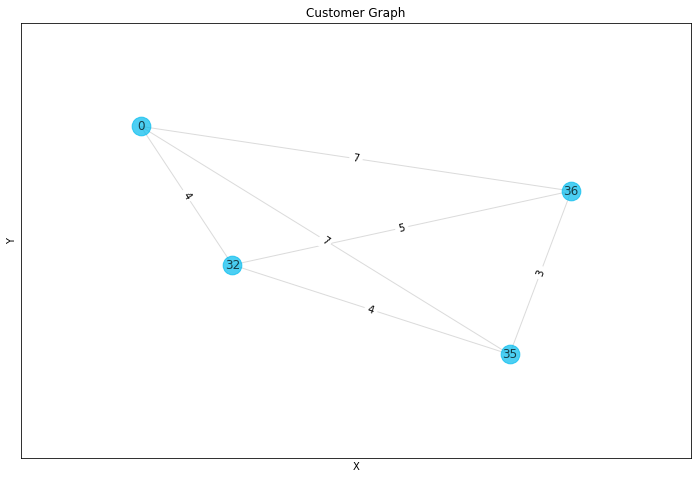

All Hamiltonian Paths from 0-36 :
 [[0, 32, 35, 36], [0, 35, 32, 36]] 

[0, 32, 35, 36]: 13.118
[0, 35, 32, 36]: 18.102
Minimum Cost for Zone 11: [0, 32, 35, 36] : 13.118


In [10]:
#Classical - Brute force solution
solutions=[]
instance=distance_matrix
for zone_id in range(len(zones)):
    nodes_for_zone=zones[zone_id]
    #instance=create_distance_matrix_for_zone(zone_id)
    print ("\n----For Zone %s----"%zone_id)
    #print ('distance matrix : \n',instance)
    X = nx.Graph()
    pos = {}
    plot_nodes(X,zone_id)
    selectedPaths = get_hamiltonian_paths(X,nodes_for_zone[3])
    print('All Hamiltonian Paths from 0-%s :\n'%nodes_for_zone[3],list(selectedPaths),'\n')
    min_cost, min_cost_path = get_min_cost_function(selectedPaths)
    print('Minimum Cost for Zone {}: {} : {}'.format(zone_id, min_cost_path, min_cost))
    
    #Create the adjacency matrix
    x=np.zeros((n,n), dtype=int)
    #for k in range(len(min_cost_path)-1):
    #    x[min_cost_path[k]][min_cost_path[k+1]]=1
    #x[min_cost_path[k+1]][0]=1
    #x=x.flatten()
    #print(x) 


    #draw_tsp_solution(X,min_cost_path,pos)
    solutions.append(min_cost_path)

In [11]:
def get_coordinates_array(xs,ys):
    coords=[[]] * len(xs)
    for i in range(len(xs)):
        coords[i]=([xs[i],ys[i]])
    return coords

def get_coordinates_array_for_zone(zone_id):
    coords=[[]] * 4
    zone_nodes=zones[zone_id]
    i=0
    for node in zone_nodes:
        coords[i]=(nodes[node]['x'],nodes[node]['y'])
        i=i+1
    return coords

def shift_solution_nodes(z, target_nodes):
    z2 = np.zeros(len(z), dtype=int)
    i = z.index(0)
    roll_by = len(z)-i
    z1 = np.roll(z,roll_by)
    for i in range(len(z)):
        z2[i] = target_nodes[z1[i]]
    return z2

def map_nodes(solution, target_nodes):
    mapped_solution=np.zeros(len(solution))
    for i in range(len(solution)):
        if (solution[i]==0):
            mapped_solution[i]=target_nodes[0]
        if (solution[i]==1):
            mapped_solution[i]=target_nodes[1]
        if (solution[i]==2):
            mapped_solution[i]=target_nodes[2]
        if (solution[i]==3):
            mapped_solution[i]=target_nodes[3]
    return mapped_solution.astype(int)

In [12]:
from qiskit.aqua.translators.ising import tsp
import sys
np.set_printoptions(threshold=1000)
#Store qubits for later use in VQE
qubitOps = []

def get_quantum_solution_for_zone(zone_id):
    target_nodes = zones[zone_id]
    print('zone: ', zone_id, 'nodes: ', target_nodes)
    coord=get_coordinates_array_for_zone(zone_id)
    print (coord)
    zone_instance=create_distance_matrix_for_zone(zone_id)
    ins = tsp.TspData(name='AMC', dim=4, coord=coord, w=zone_instance)
    qubitOp, offset = tsp.get_tsp_qubitops(ins)
    qubitOps.append(qubitOp)
    algo_input = EnergyInput(qubitOp)
    #print('Paulis: ',qubitOp.aer_paulis,'\n')
    #print('Flat Paulis: ',qubitOp.get_flat_pauli_list(),'\n')
    #print('\nmatrix: ',qubitOp.matrix,'\n')
    print('num qubits: ',qubitOp.num_qubits,'\n')

    #Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
    ee = ExactEigensolver(qubitOp, k=1)
    result = ee.run()
    print('energy:', result['energy'])
    print('tsp objective:', result['energy'] + offset)
    #print(result['eigvecs'])
    x = tsp.sample_most_likely(result['eigvecs'][0])
    print('feasible:', tsp.tsp_feasible(x))
    print(x)
    z = tsp.get_tsp_solution(x)
    print('solution:', z)
    print('solution objective:', tsp.tsp_value(z, ins.w))
    z2 = shift_solution_nodes(z, target_nodes)
    #z2=map_nodes(z2, target_nodes)
    #print('After Map: ',z2)
    #print(pos)
    #draw_tsp_solution(G, best_order, colors, pos)
    #draw_tsp_solution(X, z2, pos)
    return(z2)

In [13]:
#instance=create_distance_matrix_for_zone(-1)
for zone_id in range(len(zones)):
    q_solution=get_quantum_solution_for_zone(zone_id)
    print('TSP soln for zone :',zone_id, ' - > ', q_solution)

zone:  0 nodes:  [0, 6, 7, 8]
[(40.72374, -73.99239), (40.75213, -73.98), (40.75651, -73.992), (40.76173, -73.994)]
num qubits:  16 

energy: -1600016.559
tsp objective: 7.189000000245869
feasible: True
[0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
solution: [3, 2, 0, 1]
solution objective: 7.189
TSP soln for zone : 0  - >  [0 6 8 7]
zone:  1 nodes:  [0, 1, 2, 3]
[(40.72374, -73.99239), (40.72102, -73.983), (40.71824, -73.988), (40.72633, -73.978)]
num qubits:  16 

energy: -1600006.2550000006
tsp objective: 2.8469999993685633
feasible: True
[0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
solution: [2, 3, 1, 0]
solution objective: 2.8470000000000004
TSP soln for zone : 1  - >  [0 2 3 1]
zone:  2 nodes:  [0, 31, 33, 34]
[(40.72374, -73.99239), (40.73789, -74.053), (40.74867, -74.041), (40.75831, -74.044)]
num qubits:  16 

energy: -1600024.5640000014
tsp objective: 11.497999998508021
feasible: True
[0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
solution: [2, 3, 1, 0]
solution o

In [14]:
seed = 10598
import logging
from qiskit.aqua import set_qiskit_aqua_logging
from qiskit.aqua.translators.ising.vehicle_routing import *
set_qiskit_aqua_logging(logging.INFO)  # choose INFO, DEBUG to see the log
zone_id=2
#Get qubitOp for the zone
#qubitOp = qubitOps[zone_id]
zone_instance=create_distance_matrix_for_zone(zone_id)
zone_instance = np.asarray(zone_instance)
#zone_instance=create_euclidian_distance_matrix_for_zone(zone_id)
print(zone_instance)
qubitOp = get_vehiclerouting_qubitops(zone_instance, n, K)
#We use the VQE that needs two algorithms as sub-components
#Sub-Component 1 : a local optimizer, we use SPSA/COBYLA(Constrained Optimization BY Linear Approximation) 
#from qiskit.aqua.components.optimizers
cobyla = COBYLA()
cobyla.set_options(maxiter=200)
spsa = SPSA(max_trials=200)
#Sub-Component 2 : a variational form, we use Ry from qiskit.aqua.components.variational_forms
#ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
ry = RY(qubitOp.num_qubits, depth=3, entanglement='linear')
#vqe = VQE(qubitOp, ry, cobyla, 'matrix')
vqe = VQE(qubitOp, ry, spsa) #, 'matrix')
vqe.random_seed = seed

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_transpiler=seed)

2019-12-16 12:46:53,066:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: 
==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <qiskit.aqua.components.variational_forms.ry.RY object at 0x7f9763be8668>
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x7f9763be86a0>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x7f9763b89f60>>
-- initial_point: Random seed
-- callback: None
-- operator: Representation: paulis, qubits: 12, size: 37
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: True
Variational Form: RY
-- num_parameters: 48
-- num_qubits: 12
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)

[[0.    4.378 4.613 5.324]
 [4.378 0.    1.209 1.719]
 [4.613 1.209 0.    0.788]
 [5.324 1.719 0.788 0.   ]]


In [15]:
import time
start_time=time.time()
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
result = vqe.run(quantum_instance)
print("Ran For %s seconds" % (time.time() - start_time))
"""
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}
}
result = run_algorithm(parahms,algo_input)
"""

2019-12-16 12:47:03,371:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: When running with non-Aer statevector simulator, represent operator as a matrix could achieve the better performance. We convert the operator to matrix.
2019-12-16 12:47:03,403:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.14159265358979

2019-12-16 12:47:11,027:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 32 returned 3700.9612692101673
2019-12-16 12:47:11,188:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 33 returned 3982.779709545592
2019-12-16 12:47:11,352:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 34 returned 3376.6917449426223
2019-12-16 12:47:11,520:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 35 returned 3686.4179502077677
2019-12-16 12:47:11,700:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 36 returned 3531.178389241285
2019-12-16 12:47:11,876:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 37 returned 3669.6040788054624
2019-12-16 12:47:12,049:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 38 returned 3599.5711769362706
2019-12-16 12:47:12,208:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 39 returned 3491.031934035832
2019-12-16 12:47:12,370:qiskit.aqua.algorithms.adap

2019-12-16 12:47:18,483:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: 2555.8989775
2019-12-16 12:47:18,642:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 75 returned 2639.1143471882892
2019-12-16 12:47:18,807:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 76 returned 2438.4479757667395
2019-12-16 12:47:18,808:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 12: 2639.1143472
2019-12-16 12:47:18,808:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 12: 2438.4479758
2019-12-16 12:47:18,964:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 77 returned 2427.8164905307526
2019-12-16 12:47:19,125:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 78 returned 2528.2999876269355
2019-12-16 12:47:19,127:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 13: 2427.8164905
2019-12-16 12:47

2019-12-16 12:47:24,576:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 28: 2015.6406674
2019-12-16 12:47:24,577:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 28: 1987.3754658
2019-12-16 12:47:24,737:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 109 returned 1996.0024992005922
2019-12-16 12:47:24,897:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 110 returned 1998.273994544766
2019-12-16 12:47:24,898:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 29: 1996.0024992
2019-12-16 12:47:24,899:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 29: 1998.2739945
2019-12-16 12:47:25,055:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 111 returned 2049.8931698733945
2019-12-16 12:47:25,243:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 112 returned 1954.9847878802643
2019-12-16 12

2019-12-16 12:47:30,588:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 142 returned 1743.9456647020584
2019-12-16 12:47:30,589:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 45: 1720.0329895
2019-12-16 12:47:30,590:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 45: 1743.9456647
2019-12-16 12:47:30,753:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 143 returned 1767.7056199777142
2019-12-16 12:47:30,909:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 144 returned 1732.3577571698092
2019-12-16 12:47:30,910:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 46: 1767.7056200
2019-12-16 12:47:30,911:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 46: 1732.3577572
2019-12-16 12:47:31,079:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 145 returned 1614.4236780098126
2019-12-16 1

2019-12-16 12:47:36,500:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 175 returned 1156.7681097648613
2019-12-16 12:47:36,655:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 176 returned 1246.466943085559
2019-12-16 12:47:36,657:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 62: 1156.7681098
2019-12-16 12:47:36,657:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 62: 1246.4669431
2019-12-16 12:47:36,817:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 177 returned 1295.318375167659
2019-12-16 12:47:36,973:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 178 returned 1107.5843490675586
2019-12-16 12:47:36,975:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 63: 1295.3183752
2019-12-16 12:47:36,976:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 63: 1107.5843491
2019-12-16 12:

2019-12-16 12:47:42,452:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 78: 698.5569330
2019-12-16 12:47:42,635:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 209 returned 725.8831426931442
2019-12-16 12:47:42,840:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 210 returned 729.480189469387
2019-12-16 12:47:42,841:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 79: 725.8831427
2019-12-16 12:47:42,842:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 79: 729.4801895
2019-12-16 12:47:43,001:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 211 returned 714.5870948040076
2019-12-16 12:47:43,177:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 212 returned 757.1682332876104
2019-12-16 12:47:43,178:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 80: 714.5870948
2019-12-16 12:47:43,1

2019-12-16 12:47:48,624:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 95: 356.2669838
2019-12-16 12:47:48,625:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 95: 651.4760968
2019-12-16 12:47:48,803:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 243 returned 449.6679982751348
2019-12-16 12:47:48,958:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 244 returned 360.718926035706
2019-12-16 12:47:48,959:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 96: 449.6679983
2019-12-16 12:47:48,960:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 96: 360.7189260
2019-12-16 12:47:49,132:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 245 returned 389.7072888166941
2019-12-16 12:47:49,303:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 246 returned 398.1601161571777
2019-12-16 12:47:49,3

2019-12-16 12:47:55,398:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 276 returned 260.9748988897095
2019-12-16 12:47:55,399:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 112: 314.0644258
2019-12-16 12:47:55,400:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 112: 260.9748989
2019-12-16 12:47:55,561:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 277 returned 306.2430184202408
2019-12-16 12:47:55,721:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 278 returned 281.9888840996337
2019-12-16 12:47:55,722:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 113: 306.2430184
2019-12-16 12:47:55,723:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 113: 281.9888841
2019-12-16 12:47:56,030:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 279 returned 229.77679746004677
2019-12-16 12:4

2019-12-16 12:48:01,308:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 309 returned 165.67002649356783
2019-12-16 12:48:01,474:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 310 returned 235.8788676904536
2019-12-16 12:48:01,475:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 129: 165.6700265
2019-12-16 12:48:01,476:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 129: 235.8788677
2019-12-16 12:48:01,651:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 311 returned 209.89332801915586
2019-12-16 12:48:01,812:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 312 returned 238.6970393995241
2019-12-16 12:48:01,813:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 130: 209.8933280
2019-12-16 12:48:01,814:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 130: 238.6970394
2019-12-16 12:

2019-12-16 12:48:07,467:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 145: 188.8252931
2019-12-16 12:48:07,630:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 343 returned 165.73354046138456
2019-12-16 12:48:07,789:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 344 returned 141.99872912055034
2019-12-16 12:48:07,790:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 146: 165.7335405
2019-12-16 12:48:07,791:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 146: 141.9987291
2019-12-16 12:48:07,948:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 345 returned 163.30285237085909
2019-12-16 12:48:08,105:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 346 returned 152.1819704958814
2019-12-16 12:48:08,106:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 147: 163.3028524
2019-12-16 12

2019-12-16 12:48:13,347:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 162: 171.1623272
2019-12-16 12:48:13,348:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 162: 154.2273718
2019-12-16 12:48:13,520:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 377 returned 116.85281726382442
2019-12-16 12:48:13,720:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 378 returned 138.35046173055986
2019-12-16 12:48:13,721:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 163: 116.8528173
2019-12-16 12:48:13,722:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 163: 138.3504617
2019-12-16 12:48:14,038:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 379 returned 176.73805903917727
2019-12-16 12:48:14,201:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 380 returned 124.98722046065137
2019-12-16 1

2019-12-16 12:48:19,453:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 410 returned 136.59268705379003
2019-12-16 12:48:19,454:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 179: 94.6740174
2019-12-16 12:48:19,455:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 179: 136.5926871
2019-12-16 12:48:19,624:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 411 returned 138.08504820019584
2019-12-16 12:48:19,797:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 412 returned 130.13710355638878
2019-12-16 12:48:19,798:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 180: 138.0850482
2019-12-16 12:48:19,799:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 180: 130.1371036
2019-12-16 12:48:19,963:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 413 returned 127.18751947165866
2019-12-16 12

2019-12-16 12:48:25,543:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 443 returned 144.18774032297196
2019-12-16 12:48:25,702:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 444 returned 117.0899672591527
2019-12-16 12:48:25,703:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 196: 144.1877403
2019-12-16 12:48:25,704:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 196: 117.0899673
2019-12-16 12:48:25,861:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 445 returned 122.00809413498573
2019-12-16 12:48:26,034:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 446 returned 84.01013193258383
2019-12-16 12:48:26,043:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 197: 122.0080941
2019-12-16 12:48:26,047:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 197: 84.0101319
2019-12-16 12:4

Ran For 83.81133460998535 seconds


"\nalgorithm_cfg = {\n    'name': 'VQE',\n    'operator_mode': 'matrix'\n}\n\noptimizer_cfg = {\n    'name': 'SPSA',\n    'max_trials': 300\n}\n\nvar_form_cfg = {\n    'name': 'RY',\n    'depth': 5,\n    'entanglement': 'linear'\n}\n\nparams = {\n    'problem': {'name': 'ising', 'random_seed': seed},\n    'algorithm': algorithm_cfg,\n    'optimizer': optimizer_cfg,\n    'variational_form': var_form_cfg,\n    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}\n}\nresult = run_algorithm(parahms,algo_input)\n"

In [16]:
print(result)    
print('energy:', result['energy'])
print('time:', result['eval_time'])
quantum_solution = get_vehiclerouting_solution(zone_instance, n, K, result)
print(quantum_solution)
quantum_cost = get_vehiclerouting_cost(zone_instance, n, K, quantum_solution)
print(quantum_cost)
np.set_printoptions(threshold=sys.maxsize)
result['eigvecs'][0]

{'num_optimizer_evals': None, 'min_val': 54.356452342509385, 'opt_params': array([ 0.92403168,  0.08240983,  1.16920067,  0.02366954, -2.31034547,
       -0.36341028,  3.1124205 ,  0.04086175,  1.8077892 , -0.07738399,
        0.12950493, -1.72154444,  1.30460193, -0.06406261, -2.30162703,
       -0.01658174,  1.65156625,  0.30134386, -0.96006916,  2.97452024,
        1.92901254, -0.17810978, -1.73060816,  1.60279248, -1.91509154,
       -3.14488192, -0.57654159, -3.13595026, -0.63092722, -3.08064579,
       -0.10803764,  2.98777103,  0.27215813,  0.2857711 ,  4.35663936,
       -0.41601417, -2.87008016,  2.94932119,  1.71993795,  3.05201304,
        1.32252418,  0.07458945,  0.93869584,  0.20894565, -2.77876385,
       -0.18571454, -2.58559219,  2.82665931]), 'eval_time': 83.4975950717926, 'eval_count': 451, 'energy': 54.356452342509385, 'eigvals': array([54.35645234]), 'min_vector': array([-2.14132893e-06+0.j, -1.01986659e-04+0.j, -2.08158888e-07+0.j, ...,
       -3.82935977e-06+0.j,

array([-2.14132893e-06+0.00000000e+00j, -1.01986659e-04+0.00000000e+00j,
       -2.08158888e-07+0.00000000e+00j,  6.96239959e-06+0.00000000e+00j,
        2.39193614e-07+0.00000000e+00j, -4.06533691e-07+0.00000000e+00j,
        3.60513769e-06+0.00000000e+00j,  7.91082410e-07+0.00000000e+00j,
        1.62449092e-07+0.00000000e+00j,  7.94565569e-06+0.00000000e+00j,
        8.60449647e-09+0.00000000e+00j, -5.43608715e-07+0.00000000e+00j,
       -1.39294192e-08+0.00000000e+00j,  2.46293453e-07+0.00000000e+00j,
       -2.74286751e-07+0.00000000e+00j, -1.84072197e-07+0.00000000e+00j,
       -1.28346565e-05+0.00000000e+00j, -6.11327979e-04+0.00000000e+00j,
       -1.24569780e-06+0.00000000e+00j,  4.17345614e-05+0.00000000e+00j,
        1.43325864e-06+0.00000000e+00j, -2.50799581e-06+0.00000000e+00j,
        2.16230936e-05+0.00000000e+00j,  4.77647547e-06+0.00000000e+00j,
        6.92914052e-07+0.00000000e+00j,  3.31885745e-05+0.00000000e+00j,
        6.75495057e-08+0.00000000e+00j, -2.26530898

In [17]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
j = 0
for i in range(n ** 2):
    print (i // n, i % n)
    if i // n != i % n:
        print (j,'->',i)
        x_quantum[i] = quantum_solution[j]
        j +=  1
print(x_quantum)      

0 0
0 1
0 -> 1
0 2
1 -> 2
0 3
2 -> 3
1 0
3 -> 4
1 1
1 2
4 -> 6
1 3
5 -> 7
2 0
6 -> 8
2 1
7 -> 9
2 2
2 3
8 -> 11
3 0
9 -> 12
3 1
10 -> 13
3 2
11 -> 14
3 3
[0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]


In [18]:
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print (x)
#print('feasible:', tsp.tsp_feasible(x))
print('feasible:', tsp.tsp_feasible(x_quantum))
#x_quantum = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
if (tsp.tsp_feasible(x_quantum)==True):
    target_nodes = zones[zone_id]
    print('zone: ', zone_id, 'nodes: ', target_nodes)
    z = tsp.get_tsp_solution(x_quantum)
    print('solution:', z)
    z2 = shift_solution_nodes(z, target_nodes)
    print(z2)
    print('solution objective:', tsp.tsp_value(z, ins.w))
    draw_tsp_solution(X, z2, pos)

[1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
feasible: True
zone:  2 nodes:  [0, 31, 33, 34]
solution: [2, 0, 3, 1]
[ 0 34 31 33]


NameError: name 'ins' is not defined

In [29]:
#Aggregation
#You will have 20 z arrays - 
#[[0,1,2,3], [0,7,6,8], [0,9,11,10]...]
#3, 8, 10, .... - with these create an array
edges = []
nodes_to_join = []
k=0
for solution in solutions:
#3 & 8 - whether their distance is less than threshold
    #Select nodes to join
    for i in range(len(solution)-1):
        edges.append([solution[i],solution[i+1],'#555555',1])
    print (solution)
    if k%2==0: #Even
        nodes_to_join.append(solution[3])
    else : #Odd
        nodes_to_join.append(solution[1])
        nodes_to_join.append(solution[3])
    k=k+1

print(nodes_to_join)
continue_joining=True
while(continue_joining):
    deleted=False
    for k in range(len(nodes_to_join)-1):
        nodeA=nodes_to_join[k]
        nodeB=nodes_to_join[k+1]
        distance = math.sqrt((nodes[nodeA]['x'] - nodes[nodeB]['x']) ** 2 + (nodes[nodeA]['y'] - nodes[nodeB]['y']) ** 2)
        print(nodeA,nodeB," --- ",distance)
        if distance < 100:
            edges.append([nodeA,nodeB,'#cc0000',2])
            nodes_to_join.remove(nodeA)
            nodes_to_join.remove(nodeB)
            deleted=True
            break
    print(nodes_to_join)
    if deleted==False:
        continue_joining=False

#if it is - the join 3-8 and remove 3,8 from the array
for k in range(len(nodes_to_join)):
    edges.append([nodes_to_join[k],0,'#0000cc',2])

[0, 6, 7, 8]
[0, 2, 1, 3]
[0, 31, 33, 34]
[0, 11, 12, 13]
[0, 18, 17, 21]
[0, 20, 22, 23]
[0, 14, 16, 19]
[0, 28, 29, 30]
[0, 25, 24, 26]
[0, 4, 5, 9]
[0, 15, 10, 27]
[0, 32, 35, 36]
[8, 2, 3, 34, 11, 13, 21, 20, 23, 19, 28, 30, 26, 4, 9, 27, 32, 36]
8 2  ---  0.043901937314882476
[3, 34, 11, 13, 21, 20, 23, 19, 28, 30, 26, 4, 9, 27, 32, 36]
3 34  ---  0.07333976002142771
[11, 13, 21, 20, 23, 19, 28, 30, 26, 4, 9, 27, 32, 36]
11 13  ---  0.0222373019946268
[21, 20, 23, 19, 28, 30, 26, 4, 9, 27, 32, 36]
21 20  ---  0.0224157444667818
[23, 19, 28, 30, 26, 4, 9, 27, 32, 36]
23 19  ---  0.05538426581620711
[28, 30, 26, 4, 9, 27, 32, 36]
28 30  ---  0.028607859060057077
[26, 4, 9, 27, 32, 36]
26 4  ---  0.07031991183157846
[9, 27, 32, 36]
9 27  ---  0.07339907424484274
[32, 36]
32 36  ---  0.05640631258999836
[]
[]


In [30]:
def prepare_graph (graph):
    xs =[x0]; ys = [y0]
    nodelist=[]
    for i in range(len(xs_orig)):
        xs.append(xs_orig[i])
        ys.append(ys_orig[i])
        nodelist.append(i)
    nodelist.append(60)
    n=len(xs)
    keys = range(n)
    node_attrs_pos={}
    zones_array = np.array(zones)
    for i in nodelist:
        pos[i] = (xs[i], ys[i])
        if i==0:
            zone='HUB'
            name='HUB'
        else:
            result_tuple=np.where(zones_array==i)
            zone=result_tuple[0][0]
            name='N'+str(i)
        node_attrs_pos[i]={'name':name,'x':xs[i],'y':ys[i],'zone':zone}
    
    graph = graph.to_directed()
    #Add Nodes to graph
    graph.add_nodes_from(nodelist)
    #Set properties to nodes
    nx.set_node_attributes(graph,node_attrs_pos,'attrs')

    # Add Edges
    for edge in edges:
        graph.add_edge(edge[0], edge[1], color=edge[2], weight=edge[3])
    return graph

def plot_graph (graph):
    edges1 = graph.edges()
    colors = [graph[u][v]['color'] for u,v in edges1]
    weights = [graph[u][v]['weight'] for u,v in edges1]

    plt.figure()
    fig = plt.gcf()
    ax=fig.gca()
    fig.set_size_inches(30,26)
    plt.title('Customer Graph')
    plt.xlabel('X')
    plt.ylabel('Y')
    nx.draw_networkx(graph, pos, node_size=550, ax=ax,
                     edge_color=colors, width=weights,
                     node_color='#00bbee', alpha=0.7, with_labels=True)
    #labels = nx.get_edge_attributes(graph, "length")
    #print(labels)
    #nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    plt.grid(True)
    plt.show()

def print_data(graph):
    print(len(graph))
    for i in range(len(graph)):
        print(i,',',graph.nodes[i]['attrs']['name'],',',graph.nodes[i]['attrs']['zone'],
             ',',graph.nodes[i]['attrs']['x'],',',graph.nodes[i]['attrs']['y'])
    edges1 = graph.edges()
    for u,v in edges1:
        print (u,',',v,',',graph[u][v]['color'],',',graph[u][v]['weight'])

In [31]:
X = nx.Graph()
pos = {}
X= prepare_graph(X)
#plot_graph(X)
print_data(X)

IndexError: list index out of range

In [32]:
#Solution with 3 nodes - remove
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.translators.ising.vehicle_routing import *

# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1)
K = 1  # number of vehicles

# Get the data
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()
print (xc)
print (yc)
print (instance)
zone_id=19
xc,yc = get_xs_and_ys_for_a_zone(zone_id)
instance = create_distance_matrix_for_zone(zone_id)
print (xc)
print (yc)
print (instance, instance.shape)

[ 0.51003914  2.55963937 -0.64283509 -4.57068577]
[ 2.98724481 -2.72584275  1.05534574  0.79231007]
[[ 0.         36.84023052  5.061353   30.63150414]
 [36.84023052  0.         24.55322904 63.21893593]
 [ 5.061353   24.55322904  0.         15.49719877]
 [30.63150414 63.21893593 15.49719877  0.        ]]


IndexError: list index out of range

In [ ]:
qubitOp = get_vehiclerouting_qubitops(instance, n, K)
backend = BasicAer.get_backend('statevector_simulator')
seed = 50
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result = vqe.run(quantum_instance)
# print(result)
x_quantum2 = get_vehiclerouting_solution(instance, n, K, result)
print(x_quantum2)
quantum_cost2 = get_vehiclerouting_cost(instance, n, K, x_quantum2)
print(quantum_cost2)

2019-12-09 07:46:25,517:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "disp": false,
    "maxiter": 1000,
    "rhobeg": 1.0,
    "tol": null
}
2019-12-09 07:46:25,518:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "cobyla_schema",
    "properties": {
        "disp": {
            "default": false,
            "type": "boolean"
        },
        "maxiter": {
            "default": 1000,
            "type": "integer"
        },
        "rhobeg": {
            "default": 1.0,
            "type": "number"
        },
        "tol": {
            "default": null,
            "type": [
                "number",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-12-09 07:46:25,525:qiskit.aqua.components.optimizers.optimizer:DEBUG: options: {'maxiter': 250, 'disp': False, 'rhobeg': 1.0}
2019-12-09 07:46:25,526:qiskit.aqua.parser.json_schema:DEBUG: Input: {
  

2019-12-09 07:46:25,560:qiskit.aqua.components.optimizers.optimizer:DEBUG: WARNING: COBYLA does not support bounds. It will be ignored.
2019-12-09 07:46:26,182:qiskit.aqua.utils.run_circuits:DEBUG: ==== Before transpiler ====
2019-12-09 07:46:26,184:qiskit.aqua.utils.run_circuits:DEBUG: Submitting 1 circuits.
0-th circuit: 12 qubits, 0 classical bits and 642 operations with depth 133
op_counts: OrderedDict([('u2', 396), ('cx', 198), ('u3', 48), ('barrier', 7)])

2019-12-09 07:46:26,185:qiskit.aqua.utils.run_circuits:DEBUG: ====  After transpiler ====
2019-12-09 07:46:26,186:qiskit.aqua.utils.run_circuits:DEBUG: Submitting 1 circuits.
0-th circuit: 12 qubits, 0 classical bits and 312 operations with depth 73
op_counts: OrderedDict([('cx', 198), ('u2', 66), ('u3', 48), ('barrier', 7)])

2019-12-09 07:46:26,363:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 1 returned 65179.39436723707
2019-12-09 07:46:27,034:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation

2019-12-09 07:47:12,716:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 62 returned 23666.60827826202
2019-12-09 07:47:13,416:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 63 returned 24540.67000000501
2019-12-09 07:47:14,414:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 64 returned 24575.65950316144
2019-12-09 07:47:15,049:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 65 returned 21226.543582170158
2019-12-09 07:47:15,809:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 66 returned 19147.661588125153
2019-12-09 07:47:16,429:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 67 returned 22052.669056809456
2019-12-09 07:47:17,084:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 68 returned 21839.48006177036
2019-12-09 07:47:17,850:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 69 returned 24772.12651230718
2019-12-09 07:47:18,564:qiskit.aqua.algorithms.adapti

2019-12-09 07:48:04,094:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 131 returned 12801.679170448342
2019-12-09 07:48:04,743:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 132 returned 12415.352523168553
2019-12-09 07:48:05,477:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 133 returned 12085.2139238401
2019-12-09 07:48:06,329:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 134 returned 12895.753166685336
2019-12-09 07:48:06,969:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 135 returned 11906.590701107576
2019-12-09 07:48:07,782:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 136 returned 12026.68987073651
2019-12-09 07:48:08,379:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 137 returned 12541.681268313418
2019-12-09 07:48:09,078:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 138 returned 11743.523363791473
2019-12-09 07:48:09,926:qiskit.aqua.algorit

[ 0.51003914  2.55963937 -0.64283509 -4.57068577]
[ 2.98724481 -2.72584275  1.05534574  0.79231007]
x :  [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.]


IndexError: list index out of range

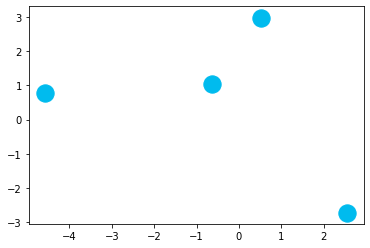

In [55]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=300, c='#00bbee')       #s -> marker size
    zone_nodes=zones[zone_id]
    for i in range(len(xc)):
        plt.annotate(zone_nodes[i], (xc[i] + 2, yc[i]+3), size=18, color='g')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()
    
    route_dict={}
    for ii in range(0, n ** 2):
        #print (ii, 'x: ',x[ii])
        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], 
                      length_includes_head=True, head_width=4)
            #print('ix: ',ix, 'iy: ', iy)
            #print ('from: ', xc[ix], yc[ix], 'to: ',xc[ix]+xc[iy] - xc[ix], 'dy: ',yc[ix]+yc[iy] - yc[ix])
            route_dict[ix]=iy

    print(route_dict)
    route=[]
    for i in range(n):
        if (i==0): 
            route.append(0)
            key=i
        route.append(zone_nodes[route_dict[key]])
        key = route_dict[key]
    route=route[0:4]
    print('VQE soln for zone : ',zone_id,' -> ',route)   
    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = x_quantum2[kk]
        kk +=  1
print(xc)
print(yc)
print('x : ',x_quantum)
# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost2, n, K, 'Quantum')    